# Algorytm SSTS #
Implementacja algorytmu na podstawie pracy "Selective Subsequence Time Series clustering", będąca przedmiotem eksperymentów w pracy inżynierskiej autorstwa Andrzeja Kołacza pt. "Grupowanie szeregów czasowych".

### WMI UWr. 2018 ###


In [1]:
import math
import time
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from os.path import join
from itertools import repeat
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

In [2]:
class Subsequence:
    def __init__(self, sequence, start, end):
        self.sequence = np.array(sequence, dtype=np.float64)
        self.start = start
        self.end = end
        
    def uniform_scaling(self, w, f):
        m = len(self.sequence)
        self.sequence = np.array([self.sequence[int(math.ceil(j*(m-1)/(w-1)))] 
                                  for j in range(w)])
    
    def z_normalize(self):
        X = self.sequence
        μ = np.mean(X, axis=0)
        σ = np.std(X, axis=0)
        if_non_zero = all(map(lambda s: s != float(0), σ))
        if if_non_zero:
            self.sequence = (X - μ)/σ
        return if_non_zero
        
class Cluster:
    def __init__(self, s1, s2):
        self.members = [s1, s2]
        self.center = self.average(s1.sequence, s2.sequence)
        self.size = 2
        
    def average(self, P, Q, w1=1, w2=1):
        return (w1*P + w2*Q)/(w1 + w2)
    
    def add_member(self, subseq):
        self.members = np.append(self.members, subseq)
        self.center = self.average(self.center, subseq.sequence,
                                   w1=self.size, w2=1)
        self.size += 1
         
    def merge(self, C):
        self.members = np.concatenate((self.members, C.members), axis=0)
        self.center = self.average(self.center, C.center, 
                                   w1=self.size, w2=C.size)
        self.size += C.size
        
    def error(self):
        return np.sum([np.linalg.norm(s.sequence - self.center) 
                       for s in self.members])
    
    def is_overlapping(self, subseq):
        start = subseq.start
        end = subseq.end
        for s in self.members:
            if start <= s.start <= end or start <= s.end <= end or \
            (s.start < start and end < s.end):
                return True
        return False

In [3]:
def print_plot(data, title='', plot_3d=True, save_plot=False):
    if data.shape[1] == 2 and plot_3d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca(projection='3d')
        ax.plot(range(data.shape[0]), data[:,0], data[:,1], c='grey')
    else:
        plt.plot(range(data.shape[0]), data, 'grey')
    plt.title(title)
    if save_plot:
        plt.savefig("{}.pdf".format(title))
    plt.show()
    
    
def print_subsequence3d(s):
    t = range(len(s.sequence))
    x = s.sequence[:,0]
    y = s.sequence[:,1]
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.plot(t, s.sequence[:,0], s.sequence[:,1], label='subs, start: {}, end: {}'.format(s.start, s.end))
    ax.legend()
    plt.show() 

####################################################    

def extract_subsequences(T, w, f):
    S = []
    L = len(T)
    w_min = int(math.ceil(w/f))
    w_max = int(math.floor(w*f))
    for i in range(w_min, w_max+1):
        for j in range(L-i+1):
            s = Subsequence(T[j:j+i], j, j+i)
            s.uniform_scaling(w, f)
            if s.z_normalize():  # we reject subsequences with standard deviation equal to 0
                S.append(s)
    return S

####################################################

def remove_subsequences(S, D, indices):
    to_remove = []
    for i in indices:
        start, end = S[i].start, S[i].end
        for j in range(len(S)):
            if start <= S[j].start <= end or start <= S[j].end <= end or \
            (S[j].start < start and end < S[j].end):
                to_remove.append(j)
    return np.delete(S, to_remove, axis=0), np.delete(D, to_remove, axis=0)


def subsequence_matching(S, D, C):
    best_so_far = np.inf
    j = None
    for i in range(len(D)):
        sqdist = np.sum((D[i] - C.center)**2)
        if sqdist < best_so_far and not C.is_overlapping(S[i]):
            best_so_far = sqdist
            j = i
    return j
            
        
def mk_algorithm(D, starts, w=25, R=7): 
    m = len(D)  # number of time series in database
    best_so_far = np.inf
    R_indices = np.array(list(map(int, np.random.rand(R) * m))) # R randomly selected indices from D
    refs = D[R_indices]  # reference time series
    
    Dist = np.zeros((R,m)) 
    for i in range(R):
        ref = R_indices[i]
        for j in range(m):
            d = np.linalg.norm(D[ref] - D[j])
            Dist[i][j] = d
            if np.abs(starts[ref] - starts[j]) >= w and d < best_so_far:
                best_so_far = d
                L1 = ref
                L2 = j
                
    # Dist(i,j) equals euclidean distance from i-th reference time series 
    # to j-th time series from database
                    
    if best_so_far == np.inf:
        return None, None
    
    Std = np.std(Dist, axis=1)
    Z = np.argsort(-Std)  # descending order of Std
    
    for i in range(R): 
        Dist[i][R_indices[i]] = np.inf

    I = np.argsort(Dist[Z[0]])  # ascending order of distances
    
    offset = 0
    abandon = False
    while abandon is False:
        offset += 1
        abandon = True
        for j in range(m-offset):
            if np.abs(starts[I[j]] - starts[I[j+offset]]) < w:
                continue
            reject = False
            for i in range(R):
                lower_bound = np.abs(Dist[Z[i]][I[j]] - Dist[Z[i]][I[j+offset]])
                if lower_bound > best_so_far:
                    reject = True
                    break
                elif i == 0:
                    abandon = False
            if reject is False:
                d = np.linalg.norm(D[I[j]] - D[I[j+offset]])
                if d < best_so_far:
                    best_so_far = d
                    L1, L2 = I[j], I[j+offset]
    
    return L1, L2

####################################################

def create_cluster(cluster_list, S, D, L, w):
    if len(S) > 1:
        starts = np.array([s.start for s in S])
        i, j = mk_algorithm(D, starts, w, R=6)
        if any([i,j]):
#             print_subsequence3d(S[i])
#             print_subsequence3d(S[j])
#             print_plot(D[i])
#             print_plot(D[j])
            C = Cluster(S[i], S[j])

            inc_error = C.error()
            u = S[i].end - S[i].start
            v = S[j].end - S[j].start
            comp_ratio = (u + v - (w + 2))/L

            cluster_list.append(C)
            S, D = remove_subsequences(S, D, [i, j])
            return cluster_list, S, D, inc_error, comp_ratio

    return [], S, D, np.inf, 0


def update_cluster(cluster_list, S, D, L):
    if len(cluster_list) and len(S):
        j = None
        min_err = np.inf
        for i in range(len(cluster_list)):
            C = copy.deepcopy(cluster_list[i])
            
            t = subsequence_matching(S, D, C)
            if t is None:
                continue
                
            C.add_member(S[t])
            err = C.error()
            if err < min_err:
                updated_C = C
                added_t = t
                j = i
                min_err = err
                
        if j is None:
            return [], S, D, np.inf, 0
        
        inc_error = min_err - cluster_list[j].error()
        u = S[added_t].end - S[added_t].start
        comp_ratio = (u - 1)/L
        
        cluster_list[j] = updated_C
        S, D = remove_subsequences(S, D, [added_t])
        return cluster_list, S, D, inc_error, comp_ratio
    
    return [], S, D, np.inf, 0


def merge_clusters(cluster_list, S, D, L, w):
    n = len(cluster_list)
    if n > 1:
        min_err = np.inf
        for i in range(n-1):
            for j in range(i+1, n):
                C1 = copy.deepcopy(cluster_list[i])
                C2 = copy.deepcopy(cluster_list[j])
                C1.merge(C2)
                err = C1.error()
                if err < min_err:
                    merged_C = C1
                    l1 = i
                    l2 = j
                    min_err = err
        
        inc_error = min_err - (cluster_list[l1].error() + cluster_list[l2].error())
        comp_ratio = w/L
        
        cluster_list[l1] = merged_C
        del cluster_list[l2]
        return cluster_list, S, D, inc_error, comp_ratio
    
    return [], S, D, np.inf, 0

####################################################

def clustering_error(cluster_list):
    return np.sum([cluster.error() for cluster in cluster_list])
    
    
def stopping_state(P, show_plots=False):
    data = np.array(P)[:,1:]
    X = np.array(data[:, 0], dtype=np.float64)
    Y = np.array(data[:, 1], dtype=np.float64)
    a, b = np.polyfit(X, Y, 1)
    
    residuas = [((a * X[i] + b) - Y[i]) for i in range(len(X))]
    
    if show_plots:
        lin = np.linspace(np.min(X),np.max(X))
        plt.plot(X, Y, label='')
        plt.xlabel('Kompresja')
        plt.ylabel('Błąd grupowania')
        plt.plot(lin, a*lin+b, label='Aproksymująca funkcja liniowa')
        plt.legend()
        plt.show()
    
    return np.argmax(residuas)

####################################################

def SSTS(T, w, f, show_plots=False):
    cluster_list = []
    compression = 0
    L = len(T)  # length of the input time series
    P = []
    S = extract_subsequences(T, w, f)
    D = np.array([s.sequence for s in S])
    
    while len(S) or len(cluster_list):
        c_list1, c_list2, c_list3 = map(copy.deepcopy, repeat(cluster_list, 3))
        s1, s2, s3 = map(copy.deepcopy, repeat(S, 3))
        
        c, s, d, err, comp = list(zip(create_cluster(c_list1, s1, D, L, w),
                                         update_cluster(c_list2, s2, D, L),
                                         merge_clusters(c_list3, s3, D, L, w)))
        m = np.argmin(err)
        cluster_list, S, D, compression_ratio = c[m], s[m], d[m], comp[m]
        
        compression += compression_ratio
        if cluster_list:
            P.append([cluster_list, compression, clustering_error(cluster_list)])
    return P, stopping_state(P, show_plots=show_plots)

In [4]:
def mark_clusters(T, cluster_list, save_plot=False, title='result.pdf', plot_3d=False):
    dimensionality = T.shape[1]
    
    if dimensionality > 2 and not plot_3d:
        pca = PCA(n_components=1)
        T = pca.fit_transform(T)
    
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    if dimensionality == 2 and plot_3d:
        fig = plt.figure(figsize=(10,10))
        ax = fig.gca(projection='3d')
        ax.plot(range(T.shape[0]), T[:,0], T[:,1], c='lightgrey')
    else:
        plt.plot(range(T.shape[0]), T, 'lightgrey')

    for i in range(len(cluster_list)):
        for s in cluster_list[i].members:
            if dimensionality == 2 and plot_3d:
                data_range = T[s.start:s.end]
                ax.plot(range(s.start, s.end), data_range[:,0], data_range[:,1], c=cycle[i%10])
            else:
                plt.plot(range(s.start, s.end), T[s.start:s.end], cycle[i%10])
    plt.title('Liczba grup: {}'.format(len(cluster_list)))
    if save_plot:
        plt.savefig(title)
    plt.show()

    
def main(data_name, data, window_size=50, scaling_factor=1, show_plots=False, save_plot=False, plot_3d=False):
    P, i = SSTS(data, window_size, scaling_factor, show_plots=show_plots)
    
    show = show_plots
    save = False
    for k in range(len(P)):
        if k == i:
            show = show_plots or True
            save = save_plot
            print('-------------------------RESULT---------------------------')
        if show:
            results = P[k]
            title = 'SSTS-{}-{}-{}-{}.pdf'.format(data_name.replace('.','_'), window_size, scaling_factor, time.strftime('%y%m%d_%H%M'))
            mark_clusters(data, results[0], save_plot=save, title=title, plot_3d=plot_3d)
            print("compression: {}\nerror: {}".format(results[1], results[2]))
        if k == i:
            show = show_plots and True
            save = False
            print('----------------------------------------------------------')
        print("\n\n\n\n")
        
    return P, i

## Uruchamianie programu ##
Aby testować program, należy pod zmienną data_name podstwić nazwę pliku z danymi w formacie '.csv', który znajduje się w tym samym folderze, co niniejszy notatnik.
Zakładamy, że dane są w poprawnej postaci, tzn. zerowa kolumna zawiera nazwy wierszy oraz usunięte zostały wszelkie opisy tekstowe.

Następnie w poniższym wywołaniu funkcji main należy dobrać parametry, z którymi chcemy przeprowadzić grupowanie:
- window_size - rozmiar sliding window - w pracy opisany jako "w"
- scaling_factor - współczynnik skalujący - "f"
- show_plots - czy program ma wyświetlać wykresy obrazujące, jak przebiegało grupowanie
- save_plots - czy program ma zapisywać wykres wynikowy
- plot_3d - czy w przypadku dwuwymiarowego szeregu czasowego program ma tworzyć wykres trójwymiarowy

W kodzie umieszczone są zakomentowane wyrażenia, dzięki którym możemy sprawdzać czy dane są prawidłowe (mimo że to założyliśmy) lub jak wyglądają podciągi wskazywane przez algorytm MK. To drugie jest wskazane, gdy spodziewamy się, że program może działać bardzo długo.

(1000, 1)


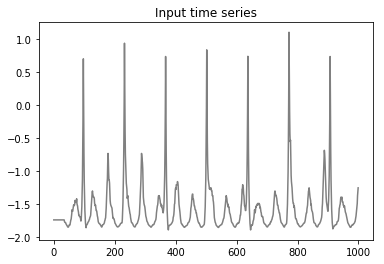

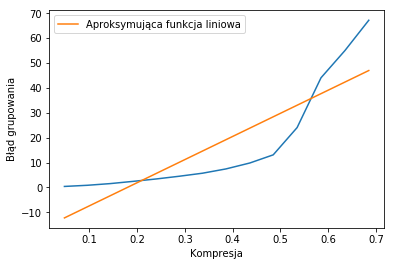

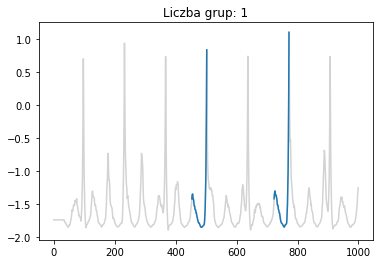

compression: 0.048
error: 0.3967891070551066







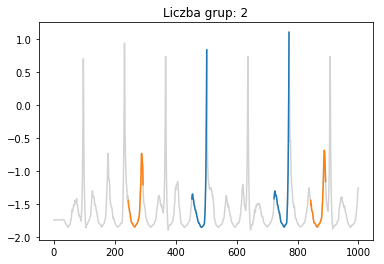

compression: 0.096
error: 0.8598511370244085







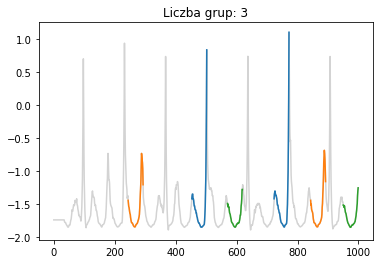

compression: 0.14400000000000002
error: 1.5394546602231158







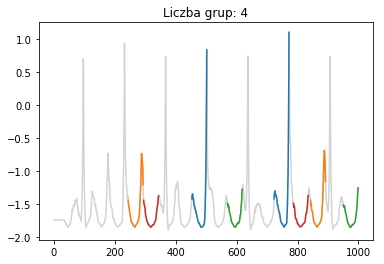

compression: 0.192
error: 2.4424551527953846







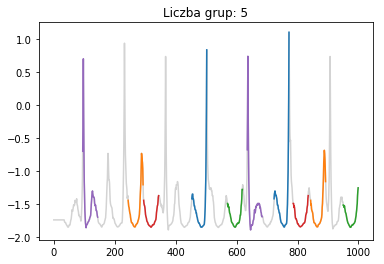

compression: 0.24
error: 3.3997632736810974







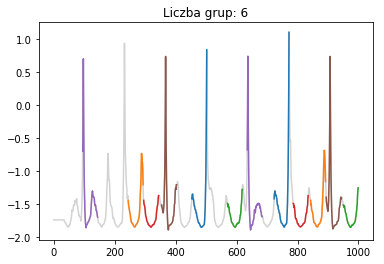

compression: 0.288
error: 4.488368463683185







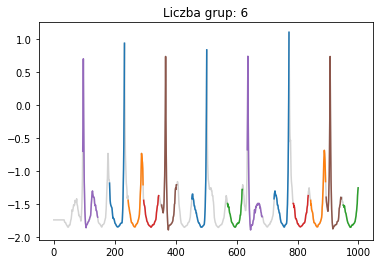

compression: 0.33699999999999997
error: 5.713351255591712







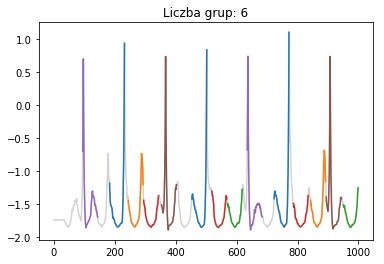

compression: 0.38599999999999995
error: 7.4336994658139615







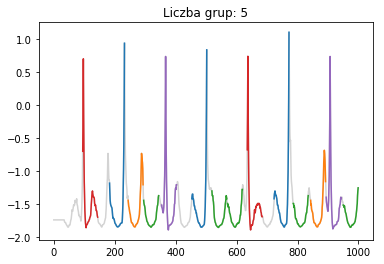

compression: 0.43599999999999994
error: 9.818355594808168





-------------------------RESULT---------------------------


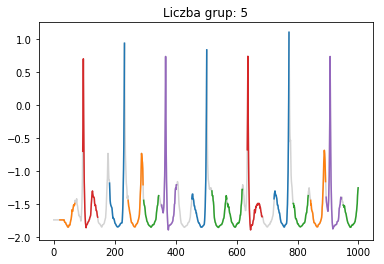

compression: 0.48499999999999993
error: 13.094811036405819
----------------------------------------------------------







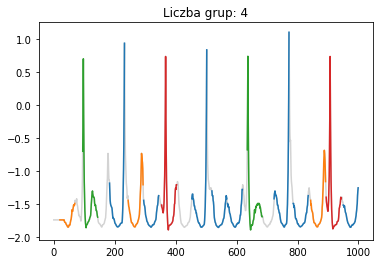

compression: 0.5349999999999999
error: 24.053737463768634







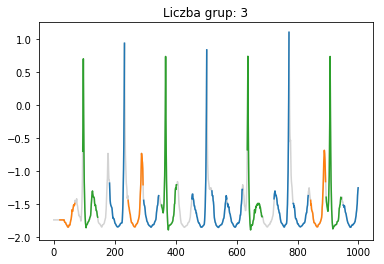

compression: 0.585
error: 44.068147977580544







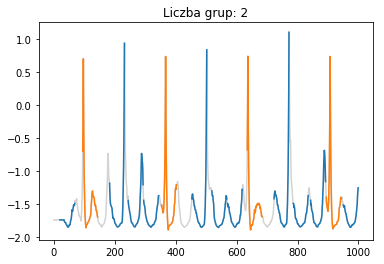

compression: 0.635
error: 54.99115867932011







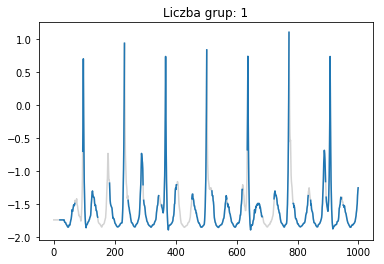

compression: 0.685
error: 67.19316150290209





time elapsed: 5.073721408843994


In [5]:
start = time.time()

data_name = 'data1.csv'
T = pd.read_csv(join('.', data_name)).values[:,1:]

# print(np.argmax(list(map(lambda x: int(np.isnan(x)), T))))

print(T.shape)
print_plot(T, title='Input time series', plot_3d=False)

P, i = main(data_name, T, window_size=50, scaling_factor=1, show_plots=True, save_plot=False, plot_3d=False)

print('time elapsed:',time.time() - start)